# MLOceanEnsemble for the Basin

Basis for ML-drifter implementation

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "k"
plt.rcParams["text.color"] = "k"
plt.rcParams["axes.labelcolor"] = "k"
plt.rcParams["xtick.color"] = "k"
plt.rcParams["ytick.color"] = "k"

plt.rcParams["image.origin"] = "lower"

from importlib import reload

import pycuda.driver as cuda

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common, WindStress
from gpuocean.SWEsimulators import CDKLM16, ModelErrorKL
from gpuocean.drifters import CPUDrifterCollection, BaseDrifterCollection


In [3]:
%cuda_context_handler gpu_ctx

In [4]:
gpu_stream = cuda.Stream()

Basin utils

In [5]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *
from utils.BasinPlot import * 
from utils.BasinParameters import * 
from utils.BasinEnsembleInit import * 

## ML ensemble

In [6]:
ls = [6, 7, 8, 9]

In [7]:
args_list = []

for l in ls:
    lvl_grid_args = initGridSpecs(l)
    args_list.append( {
        "nx": lvl_grid_args["nx"],
        "ny": lvl_grid_args["ny"],
        "dx": lvl_grid_args["dx"],
        "dy": lvl_grid_args["dy"],
        "gpu_ctx": gpu_ctx,
        "gpu_stream": gpu_stream,
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
        } )

In [8]:
data_args_list = []

for l_idx in range(len(ls)):
    data_args_list.append( make_init_steady_state(args_list[l_idx], a=steady_state_bump_a, bump_fractal_dist=steady_state_bump_fractal_dist) )


In [9]:
for l_idx in range(len(ls)):
    print(data_args_list[l_idx]['eta'][2:-2,2:-2].shape)

(128, 64)
(256, 128)
(512, 256)
(1024, 512)


In [10]:
T = 900

In [11]:
#ML_Nes = [100, 75, 50, 25] # From Flo. Takes 1m24s to init, 3m13s to run to T=900
ML_Nes = [30, 20, 15, 10] # init: 34s, run: 1m36s


In [12]:
ML_ensemble = initMLensemble(ML_Nes, args_list, data_args_list, sample_args, 
                             init_model_error_basis_args=init_model_error_basis_args, 
                             sim_model_error_basis_args=sim_model_error_basis_args, sim_model_error_time_step=sim_model_error_timestep)

0
1
2
3


In [13]:
from gpuocean.ensembles import MultiLevelOceanEnsemble

In [14]:
reload(MultiLevelOceanEnsemble)
MLOceanEnsemble = MultiLevelOceanEnsemble.MultiLevelOceanEnsemble(ML_ensemble)

In [15]:
MLOceanEnsemble.step(90) # T

In [16]:
eta00, hu00, hv00 = MLOceanEnsemble.ML_ensemble[0][0].download(interior_domain_only=True)
Hi00, Hm00 = MLOceanEnsemble.ML_ensemble[0][0].downloadBathymetry(interior_domain_only=False)
print(Hi00.shape, Hm00.shape)

(133, 69) (132, 68)


(1024, 512)


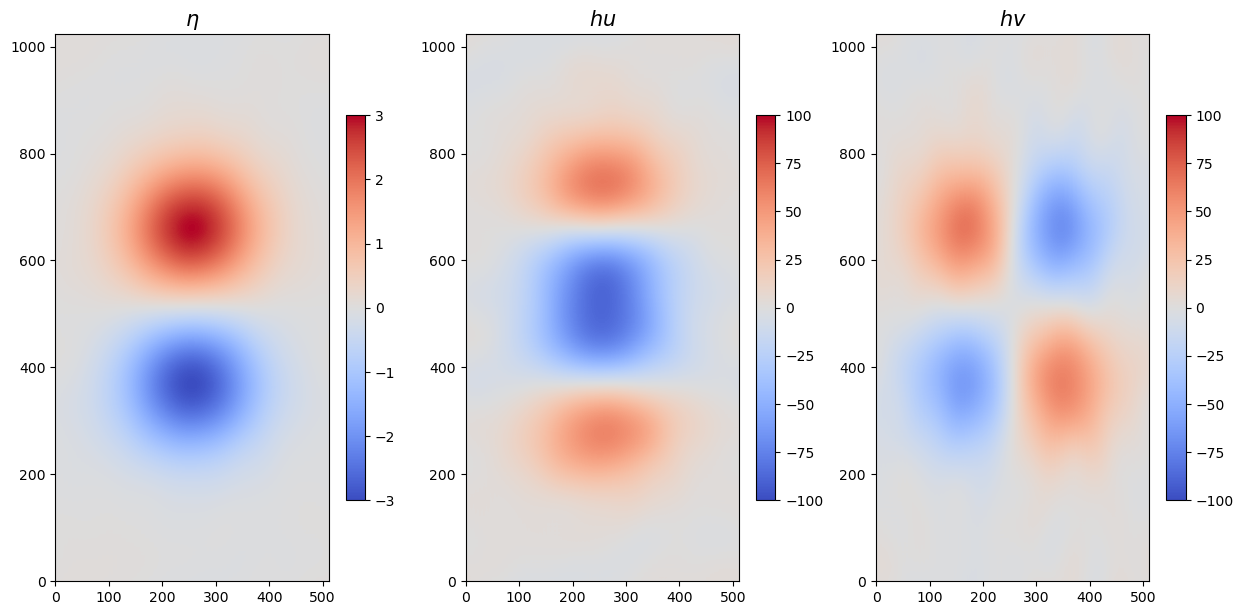

In [17]:
MLmean = MLOceanEnsemble.estimate(np.mean)
imshow3(MLmean)
print(MLmean[0].shape)

(<Figure size 1500x1000 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

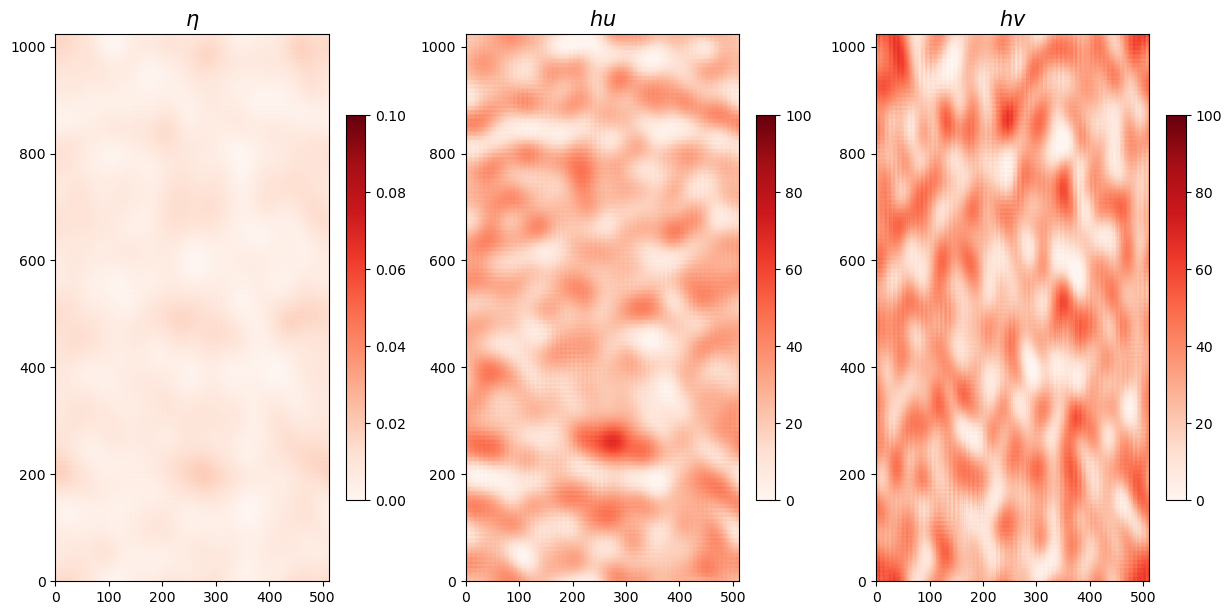

In [24]:
MLvar = MLOceanEnsemble.estimate(np.var)
imshow3var(MLvar, eta_vlim=0.1, huv_vlim=100)

In [19]:
downloadedVelocities = MLOceanEnsemble.downloadVelocities()

(1024, 512)


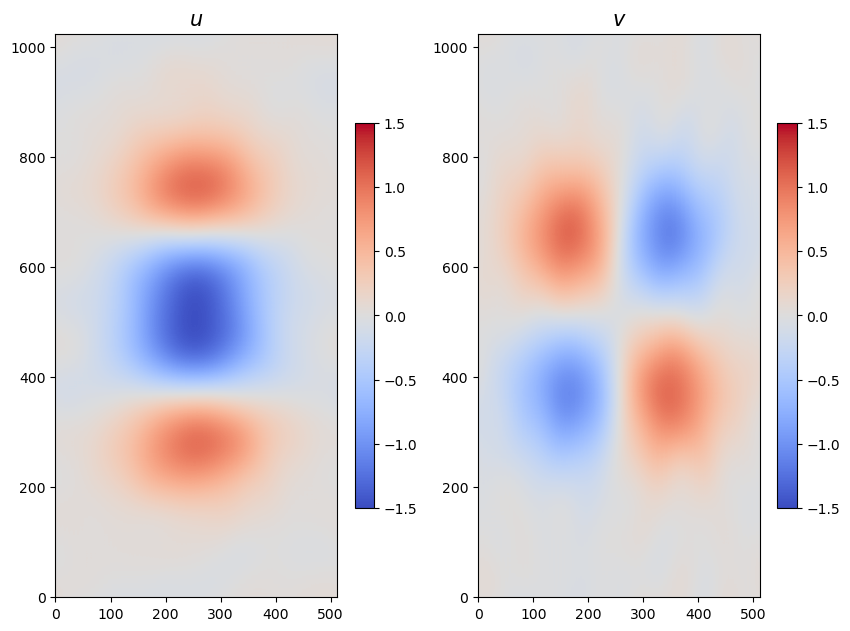

In [20]:
MLVelMean = MLOceanEnsemble.estimateVelocity(np.mean)
imshow2(MLVelMean, uv_vlim=1.5)
print(MLVelMean[0].shape)

(<Figure size 1000x1000 with 4 Axes>,
 array([<AxesSubplot:title={'center':'$u$'}>,
        <AxesSubplot:title={'center':'$v$'}>], dtype=object))

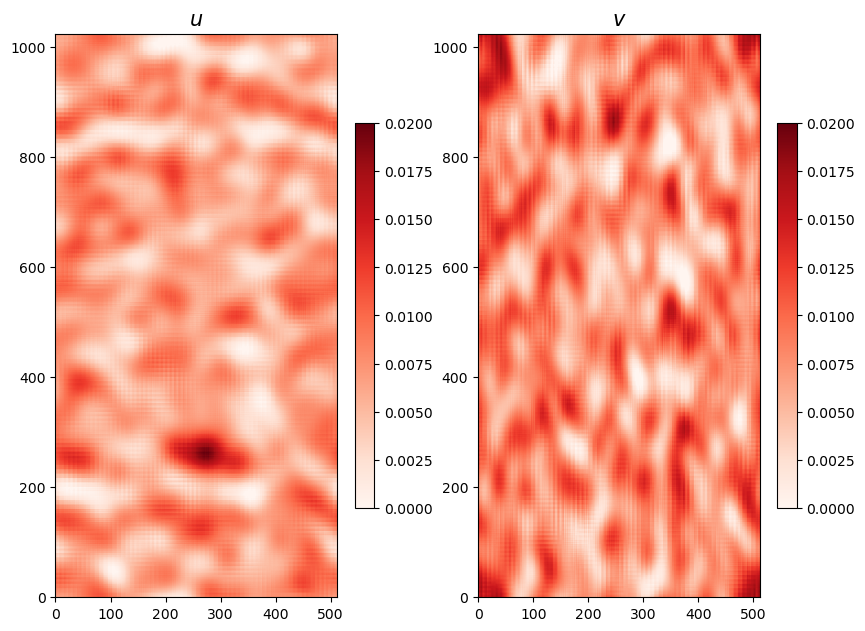

In [21]:
MLVelVar = MLOceanEnsemble.estimateVelocity(np.var)
imshow2var(MLVelVar, uv_vlim=0.02)


# Experiment with drifters:

1) make drifter object and attach drifters to sim (input: ensemble members, initial drifter positions)
    --> num(drifters) = num (init positions) + num(ensemble members) 
1) Write to observation files --> should be num(ensemble members) files, each with num(init positions) drifters
    --> make a list of observation objects, and set drifter positions to each directly
1) step sim with step sizes = drift_dt
1) Compute mean and variance of (u, v)
1) Step drifters drifter_dt
  --> store drift positions on a sparser format than drift_dt
1) Write to observation files

In [26]:
from gpuocean.drifters import CPUDrifterCollection, MLDrifterCollection

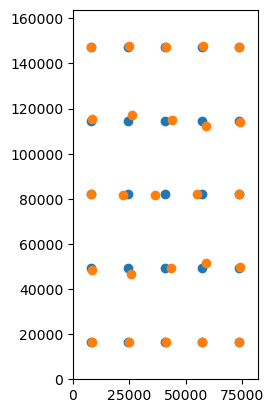

In [27]:
## Attach drifters to ensemble
from importlib import reload
reload(CPUDrifterCollection)

MLOceanEnsemble.ML_ensemble[0][0].boun

domain_size_x = MLOceanEnsemble.ML_ensemble[0][0].dx*MLOceanEnsemble.ML_ensemble[0][0].nx
domain_size_y = MLOceanEnsemble.ML_ensemble[0][0].dy*MLOceanEnsemble.ML_ensemble[0][0].ny
cpudrifters = CPUDrifterCollection.CPUDrifterCollection(25,
                                                        boundaryConditions=MLOceanEnsemble.ML_ensemble[0][0].boundary_conditions,
                                                        domain_size_x=domain_size_x,
                                                        domain_size_y=domain_size_y)

cpudrifter_positions = cpudrifters.getDrifterPositions()
plt.scatter(cpudrifter_positions[:, 0], cpudrifter_positions[:, 1])
plt.xlim(0, domain_size_x)
plt.ylim(0, domain_size_y)
plt.gca().set_aspect('equal')


cpudrifters.drift(MLmean[0], MLmean[1], MLmean[2], np.max(Hm00), 
                  MLOceanEnsemble.ML_ensemble[-1][0][0].dx, MLOceanEnsemble.ML_ensemble[-1][0][0].dy, 
                  dt=60, sensitivity=50)
cpudrifter_positions = cpudrifters.getDrifterPositions()
plt.scatter(cpudrifter_positions[:, 0], cpudrifter_positions[:, 1])
            

In [29]:
reload(MLDrifterCollection)
mldrifters = MLDrifterCollection.MLDrifterCollection(3, 2,
                                                     boundaryConditions=MLOceanEnsemble.ML_ensemble[0][0].boundary_conditions,
                                                     domain_size_x=domain_size_x,
                                                     domain_size_y=domain_size_y)
print(mldrifters.getDrifterPositions())
print(mldrifters.getDrifterPositionsForDrifter(0))
print(mldrifters.getDrifterPositionsForEnsembleMember(1))

[[ 20480.  40960.]
 [ 20480.  40960.]
 [ 61440.  40960.]
 [ 61440.  40960.]
 [ 20480. 122880.]
 [ 20480. 122880.]]
[[20480. 40960.]
 [20480. 40960.]]
[[ 20480.  40960.]
 [ 61440.  40960.]
 [ 20480. 122880.]]


In [ ]:
mldownload = MLOceanEnsemble.download()

mldownloadVel = MLOceanEnsemble.downloadVelocities(interior_domain_only=True)

In [ ]:
def print_ml_shapes(mlstruct):
    print(len(mlstruct))
    print(0, len(mlstruct[0]), mlstruct[0].shape)
    for i in range(1, len(mlstruct)):
        print(i, mlstruct[i][0].shape, mlstruct[i][1].shape)

print('normal download (interior_domain_only = True)')
print_ml_shapes(mldownload)
print("download velocities (interior_domain_only = True)")
print_ml_shapes(mldownloadVel)



normal download (interior_domain_only = True)
4
0 3 (3, 128, 64, 30)
1 (3, 256, 128, 20) (3, 128, 64, 20)
2 (3, 512, 256, 15) (3, 256, 128, 15)
3 (3, 1024, 512, 10) (3, 512, 256, 10)
download velocities (interior_domain_only = True)
4
0 2 (2, 128, 64, 30)
1 (2, 256, 128, 20) (2, 128, 64, 20)
2 (2, 512, 256, 15) (2, 256, 128, 15)
3 (2, 1024, 512, 10) (2, 512, 256, 10)


In [55]:
print(0, MLOceanEnsemble.ML_ensemble[0][0].model_time_step)
for i in range(1, len(MLOceanEnsemble.ML_ensemble)):
    print(i, MLOceanEnsemble.ML_ensemble[i][0][0].model_time_step, MLOceanEnsemble.ML_ensemble[i][1][0].model_time_step)
#    print(i, mlstruct[i][0].shape, mlstruct[i][1].shape)

print(MLOceanEnsemble.dxs)

0 60.0
1 60.0 60.0
2 60.0 60.0
3 60.0 60.0
[1280.  640.  320.  160.]


In [57]:
MLOceanEnsemble.ML_ensemble[0][0].model_time_step >= 60

True

c:\Users\havardh\Miniconda3\envs\gpuocean-extra\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


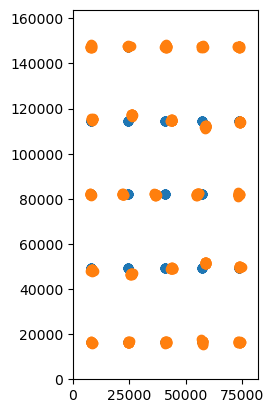

In [45]:
## Attach drifters to ensemble
reload(CPUDrifterCollection)
reload(MLDrifterCollection)
mldrifters = MLDrifterCollection.MLDrifterCollection(25, 20,
                                                     boundaryConditions=MLOceanEnsemble.ML_ensemble[0][0].boundary_conditions,
                                                     domain_size_x=domain_size_x,
                                                     domain_size_y=domain_size_y)

mldrifter_positions = mldrifters.getDrifterPositions()
pos6_init = mldrifters.getDrifterPositionsForDrifter(6)

plt.scatter(mldrifter_positions[:, 0], mldrifter_positions[:, 1])
plt.xlim(0, domain_size_x)
plt.ylim(0, domain_size_y)
plt.gca().set_aspect('equal')


mldrifters.drift(MLVelMean[0], MLVelMean[1], 
                  MLOceanEnsemble.ML_ensemble[-1][0][0].dx, MLOceanEnsemble.ML_ensemble[-1][0][0].dy, 
                  dt=60, sensitivity=50,
                  #u_stddev=MLVelVar[0], v_stddev=MLVelVar[1])
                  u_stddev=10*MLVelVar[0], v_stddev=10*MLVelVar[1])
mldrifter_positions = mldrifters.getDrifterPositions()
pos6 = mldrifters.getDrifterPositionsForDrifter(6)

plt.scatter(mldrifter_positions[:, 0], mldrifter_positions[:, 1])
            

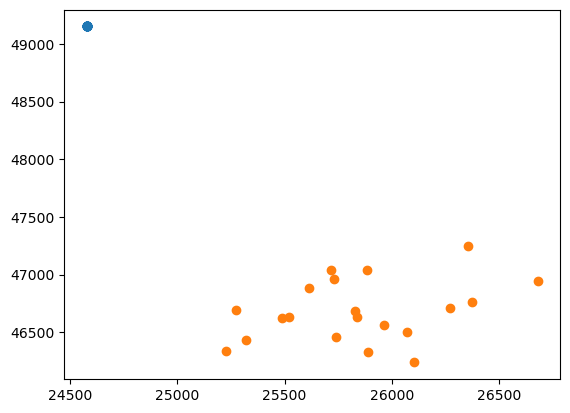

In [46]:

plt.scatter(pos6_init[:, 0], pos6_init[:, 1])

plt.scatter(pos6[:, 0], pos6[:, 1])


In [ ]:
x = 1
dx = 10
x_zero_ref = 2

cell_id_x = int(np.ceil(x/dx + x_zero_ref))
frac_x = x/dx - np.floor(x/dx)

print(cell_id_x, frac_x)


3 0.1


In [ ]:
cell_id_x0 = cell_id_x - 1 if frac_x < 0.5 else cell_id_x
x_factor = frac_x + 0.5 if frac_x < 0.5 else frac_x - 0.5
print(cell_id_x0, x_factor)

2 0.6


In [ ]:
nx, ny = MLvar[1].shape
print(nx)

1024


In [49]:
MLOceanEnsemble.nxs * MLOceanEnsemble.dxs
mldrifters.positions.shape

(501, 2)